In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [117]:
data = pd.read_csv("dataset/modeling_data.csv")

In [119]:
data.sample(3)

,stress_total,education,age,relationship,pre_meditation_frequency,gender,race,wellbeing_t0_m,wellbeing_t1_m,days_used,total_elapsed_time,total_session_completed,prac_learn_ratio,cv_daily_elapsed_time,cv_interval,lcs_score_sum,4_week_after,8_week_after
110413,26,college_or_higher,55-,having_partner,no_experience,female,white,12.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
152371,30,NaN,NaN,NaN,NaN,NaN,NaN,13.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
88737,20,college_or_higher,55-,having_partner,no_experience,female,white,14.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0


In [121]:
missing_ratio = data.isnull().mean() * 100
print(missing_ratio.sort_values(ascending=False))

cv_interval                 90.807067
cv_daily_elapsed_time       90.368339
prac_learn_ratio            90.053993
lcs_score_sum               88.617385
days_used                   88.611731
total_elapsed_time          88.611731
total_session_completed     88.611731
wellbeing_t1_m              81.293004
race                        63.419929
gender                      63.287067
pre_meditation_frequency    63.201131
education                   63.194912
age                         63.134417
relationship                63.132155
wellbeing_t0_m               3.687915
4_week_after                 0.000000
stress_total                 0.000000
8_week_after                 0.000000
dtype: float64


## Cleaning Missing Data

In [185]:
## Omit rows whose missing rate exceeds 30% of all columns
row_na_ratio = data.isna().mean(axis=1)
data_cleaned = data[row_na_ratio <= 0.3]

In [187]:
missing_ratio = data_cleaned.isnull().mean() * 100
print(missing_ratio.sort_values(ascending=False))

cv_interval                 20.114585
cv_daily_elapsed_time       16.122805
prac_learn_ratio            12.984182
wellbeing_t1_m               1.587994
wellbeing_t0_m               1.071117
race                         0.560468
gender                       0.336281
lcs_score_sum                0.043592
pre_meditation_frequency     0.012455
age                          0.006227
stress_total                 0.000000
4_week_after                 0.000000
days_used                    0.000000
total_session_completed      0.000000
total_elapsed_time           0.000000
education                    0.000000
relationship                 0.000000
8_week_after                 0.000000
dtype: float64


In [189]:
data_cleaned.shape

(16058, 18)

In [129]:
data_cleaned['8_week_after'].value_counts(normalize=True)

8_week_after
0    0.662493
1    0.337507
Name: proportion, dtype: float64

## Train-test Split

In [131]:
# split datsets into helidin/heldout set
from sklearn.model_selection import train_test_split
X = data_cleaned.drop(['8_week_after', '4_week_after'], axis='columns')
y = data_cleaned['8_week_after']
X_heldin, X_heldout, y_heldin, y_heldout = train_test_split(X,y,test_size=0.2, random_state = 112)

In [133]:
# split heldin datsets into train, valid sets
X_train, X_valid, y_train, y_valid = train_test_split(X_heldin,y_heldin, test_size=0.2, random_state = 113)

In [135]:
print(X_train.shape)
print(X_valid.shape)
print(X_heldout.shape)
print(y_train.shape)
print(y_valid.shape)
print(y_heldout.shape)

(19218, 16)
(4805, 16)
(6006, 16)
(19218,)
(4805,)
(6006,)


## Multiple Imputation (MICE)

In [27]:
import miceforest as mf

In [137]:
for col in X_train:
    if X_train[col].dtypes == 'object':
        X_train[col] = X_train[col].astype("category")

for col in X_valid:
    if X_valid[col].dtypes == 'object':
        X_valid[col] = X_valid[col].astype("category")

In [139]:
orig_idx = X_train.index

X_train_fix = X_train.reset_index(drop=True).copy()
y_train_fix = y_train.reindex(orig_idx).reset_index(drop=True).copy()

In [141]:
kernel = mf.ImputationKernel(
    data = X_train_fix,
    num_datasets=10,
    save_all_iterations_data=True,
    random_state = 1,
    mean_match_candidates=0)

In [143]:
# index 일치
np.mean(X_train_fix.index.to_numpy() == y_train_fix.index.to_numpy())

1.0

In [145]:
kernel.mice(iterations=5, verbose = True)

Initialized logger with name MICE Iterations 1 - 5 and 4 levels
1 Dataset 0
 | cv_interval | cv_daily_elapsed_time | prac_learn_ratio | lcs_score_sum | days_used | total_elapsed_time | total_session_completed | race | gender | pre_meditation_frequency | age | education | relationship | wellbeing_t1_m | wellbeing_t0_m
Dataset 1
 | cv_interval | cv_daily_elapsed_time | prac_learn_ratio | lcs_score_sum | days_used | total_elapsed_time | total_session_completed | race | gender | pre_meditation_frequency | age | education | relationship | wellbeing_t1_m | wellbeing_t0_m
Dataset 2
 | cv_interval | cv_daily_elapsed_time | prac_learn_ratio | lcs_score_sum | days_used | total_elapsed_time | total_session_completed | race | gender | pre_meditation_frequency | age | education | relationship | wellbeing_t1_m | wellbeing_t0_m
Dataset 3
 | cv_interval | cv_daily_elapsed_time | prac_learn_ratio | lcs_score_sum | days_used | total_elapsed_time | total_session_completed | race | gender | pre_meditation

In [147]:
X_train_imp = [kernel.complete_data(dataset=i) for i in range(10)]

In [149]:
for i in range(10):
    print((X_train_imp[i].index == y_train_fix.index).all())

True
True
True
True
True
True
True
True
True
True


In [151]:
X_valid_fix=X_valid.reset_index(drop=True).copy()
y_valid_fix=y_valid.reset_index(drop=True).copy()

X_valid_imp = kernel.impute_new_data(X_valid_fix).complete_data(0)
X_valid_imp = pd.DataFrame(X_valid_imp, columns=X_valid_fix.columns, index=X_valid_fix.index)

In [153]:
print((X_valid_imp.index == y_valid_fix.index).all())

True


In [155]:
X_train_imp[0].dtypes

stress_total                   int64
education                   category
age                         category
relationship                category
pre_meditation_frequency    category
gender                      category
race                        category
wellbeing_t0_m               float64
wellbeing_t1_m               float64
days_used                    float64
total_elapsed_time           float64
total_session_completed      float64
prac_learn_ratio             float64
cv_daily_elapsed_time        float64
cv_interval                  float64
lcs_score_sum                float64
dtype: object

## One Hot encoding

In [157]:
cat_columns = ['education', 'age', 'relationship', 'pre_meditation_frequency', 'gender', 'race']

# train set
for i in range(10):
    # one hot encoding for categorical variables
    X_train_imp[i] = pd.get_dummies(data=X_train_imp[i], columns = cat_columns, drop_first = True)
    
    for col in X_train_imp[i].columns:
        if X_train_imp[i][col].dtypes == 'bool':
            X_train_imp[i][col] = X_train_imp[i][col].astype(int)

# validation set
X_valid_imp = pd.get_dummies(data=X_valid_imp, columns = cat_columns, drop_first = True)
for col in X_valid_imp:
    if X_valid_imp[col].dtypes == 'bool':
        X_valid_imp[col] = X_valid_imp[col].astype(int)

## Standard scaling

In [159]:
from sklearn.preprocessing import StandardScaler
scaling_column = ['wellbeing_t1_m', 'wellbeing_t0_m', 
                 'days_used', 'total_elapsed_time', 'total_session_completed', 'prac_learn_ratio', 'cv_daily_elapsed_time',
                 'cv_interval', 'lcs_score_sum']
X_train_imp_scaled = []
scalers = []

# train set
for i in range(10):
    scaler = StandardScaler()
    Xt = X_train_imp[i].copy()
    Xt[scaling_column] = scaler.fit_transform(Xt[scaling_column])
    X_train_imp_scaled.append(Xt)
    scalers.append(scaler)

# validation set
X_valid_imp_scaled = X_valid_imp.copy()
X_valid_imp_scaled[scaling_column] = scaler.transform(X_valid_imp_scaled[scaling_column])

## MLP

In [51]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

Author: Sebastian Raschka

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.25.0

torch: 2.8.0



In [53]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import time

In [161]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# transform dataset to Tensor

# X_train
X_train_tensor = []

for i in range(10):
    X_np = X_train_imp_scaled[i].to_numpy(dtype = np.float32)
    X_tensor = torch.tensor(X_np, dtype=torch.float32, device=DEVICE)
    X_train_tensor.append(X_tensor)

# X_valid
X_valid_np = X_valid_imp_scaled.to_numpy(dtype=np.float32)
X_valid_tensor = torch.tensor(X_valid_np, dtype = torch.float32, device =DEVICE)

# y_train/y_valid
y_train_np = y_train_fix.to_numpy(dtype=np.int64)
y_valid_np = y_valid_fix.to_numpy(dtype=np.int64)
y_train_tensor = torch.tensor(y_train_np, dtype = torch.long, device = DEVICE)
y_valid_tensor = torch.tensor(y_valid_np, dtype = torch.long, device = DEVICE)

In [163]:
print(X_train_tensor[0].shape)
print(X_valid_tensor.shape)
print(y_train_tensor.shape)
print(y_valid_tensor.shape)

torch.Size([19218, 27])
torch.Size([4805, 27])
torch.Size([19218])
torch.Size([4805])


In [177]:
##########################
### SETTINGS
##########################

RANDOM_SEED = 120
BATCH_SIZE = 256
NUM_HIDDEN_1 = 50
NUM_HIDDEN_2 = 25
DROP_PROBA = 0.3
NUM_EPOCHS = 500
LEARNING_RATE = 0.1

In [179]:
## Modeling
class MultilayerPerceptron(torch.nn.Module):

    def __init__(self, num_features, num_classes, drop_proba, 
                 num_hidden_1, num_hidden_2):
        super(MultilayerPerceptron, self).__init__()

        self.my_network = torch.nn.Sequential(
            # 1st hidden layer
            torch.nn.Linear(num_features, num_hidden_1, bias=False),
            torch.nn.BatchNorm1d(num_hidden_1),
            torch.nn.ReLU(),
            torch.nn.Dropout(drop_proba),
            # 2nd hidden layer
            torch.nn.Linear(num_hidden_1, num_hidden_2, bias=False),
            torch.nn.BatchNorm1d(num_hidden_2),
            torch.nn.ReLU(),
            torch.nn.Dropout(drop_proba),
            # Ouput layer
            torch.nn.Linear(num_hidden_2, num_classes)
        )

    def forward(self,x):
        logits = self.my_network(x)
        probas = torch.sigmoid(logits)
        return logits, probas

In [181]:
# Model Initialization
torch.manual_seed(RANDOM_SEED)
model = MultilayerPerceptron(num_features = 27,
                             num_classes = 2,
                             drop_proba = DROP_PROBA,
                             num_hidden_1 = NUM_HIDDEN_1,
                             num_hidden_2 = NUM_HIDDEN_2
                             )
model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), LEARNING_RATE)

In [183]:
# training
start_time = time.time()
minibatch_cost = []
epoch_cost = []
i = 9

for epoch in range(NUM_EPOCHS):
    model.train()
    n_samples = X_train_tensor[i].shape[0]
    batch_size = BATCH_SIZE
    
    for start in range(0, n_samples, batch_size):
        end = start + batch_size
    
        features = X_train_tensor[i][start:end].to(DEVICE)
        targets = y_train_tensor[start:end].to(DEVICE)
    
        ## FOARWARD & BACKWARD
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
    
        minibatch_cost.append(cost.item())
    
        ## LOGGING
        if start//batch_size%100 ==0:
            print(f"Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d}|"
                  f"Batch {start//batch_size:03d} | Cost: {cost.item():.4f}")
    
    ## EPOCH-END COST & ACC
    model.eval()
    with torch.no_grad():
        logits, probas = model(X_train_tensor[i].to(DEVICE))
        loss_epoch = F.cross_entropy(logits, y_train_tensor.to(DEVICE)).item()
        preds = torch.argmax(probas, dim=1)
        acc_epoch = (preds == y_train_tensor.to(DEVICE)).float().mean().item()
    epoch_cost.append(loss_epoch)
    
    print(f"Iteration: {i} | Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} "
          f"Train Cost: {loss_epoch:.4f} | Train Acc: {acc_epoch:.4f}")
    print(f"Time elapsed: {(time.time() - start_time)/60:.2f} min")
    
print(f"Total Training Time: {(time.time() - start_time)/60:.2f} min")

## Validation (after training)
model.eval()
with torch.no_grad():
    logits_v, probas_v = model(X_valid_tensor.to(DEVICE))
    val_loss = F.cross_entropy(logits_v, y_valid_tensor.to(DEVICE)).item()
    val_preds = torch.argmax(probas_v, dim=1)
    val_acc = (val_preds == y_valid_tensor.to(DEVICE)).float().mean().item()
print(f"Validation | Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

Epoch: 001/500|Batch 000 | Cost: 0.6859
Iteration: 9 | Epoch: 001/500 Train Cost: 0.6266 | Train Acc: 0.6655
Time elapsed: 0.00 min
Epoch: 002/500|Batch 000 | Cost: 0.6250
Iteration: 9 | Epoch: 002/500 Train Cost: 0.6249 | Train Acc: 0.6677
Time elapsed: 0.00 min
Epoch: 003/500|Batch 000 | Cost: 0.6285
Iteration: 9 | Epoch: 003/500 Train Cost: 0.6246 | Train Acc: 0.6688
Time elapsed: 0.00 min
Epoch: 004/500|Batch 000 | Cost: 0.6362
Iteration: 9 | Epoch: 004/500 Train Cost: 0.6233 | Train Acc: 0.6702
Time elapsed: 0.00 min
Epoch: 005/500|Batch 000 | Cost: 0.6287
Iteration: 9 | Epoch: 005/500 Train Cost: 0.6223 | Train Acc: 0.6709
Time elapsed: 0.00 min
Epoch: 006/500|Batch 000 | Cost: 0.6285
Iteration: 9 | Epoch: 006/500 Train Cost: 0.6215 | Train Acc: 0.6710
Time elapsed: 0.00 min
Epoch: 007/500|Batch 000 | Cost: 0.6240
Iteration: 9 | Epoch: 007/500 Train Cost: 0.6214 | Train Acc: 0.6703
Time elapsed: 0.00 min
Epoch: 008/500|Batch 000 | Cost: 0.6267
Iteration: 9 | Epoch: 008/500 Train 

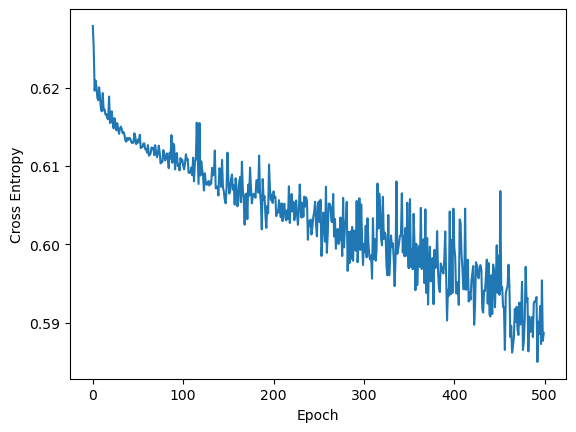

In [173]:
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.show()

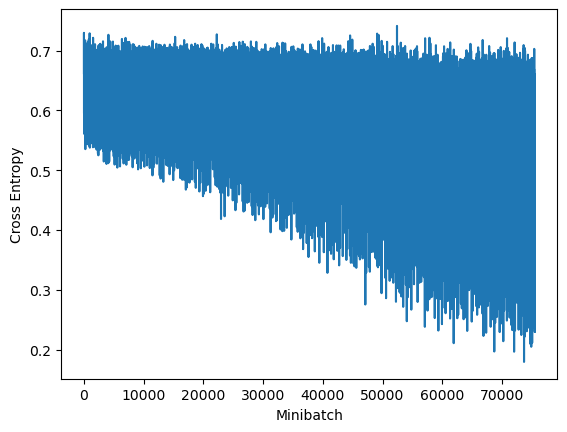

In [175]:
plt.plot(range(len(minibatch_cost)), [minibatch_cost[i] for i in range(len(minibatch_cost))])
plt.ylabel('Cross Entropy')
plt.xlabel('Minibatch')
plt.show()